In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from copy import deepcopy

In [3]:
import svg
from hehe2 import *
from IPython.display import SVG, display

In [4]:
def show_svg(canvas: svg.SVG):
    display(SVG(str(canvas)))

In [5]:
def test_ValuedArrow_func():
    arrows = {2: ['←','→'], 3: [ "↑", "↓"], 6: ["↖","↘"]}
    for j in [2,3,6]:
        for i in range(j):
            va = ValuedArrow(arrows[j][0], i)
            assert va.func() == (va.x - i)/j
            va = ValuedArrow(arrows[j][1], i)
            assert va.func() == j*va.x + i

    for j in range(6):
        east = j%3
        south = j%2
        va = ValuedArrow("↙",j)
        assert va.func() == ((3*va.x+east)-south)/2
        va2 = ValuedArrow("↗",j)
        assert compose(va.func(), va2.func()) == va.x
test_ValuedArrow_func()

TypeError: compose() missing 1 required positional argument: 'x'

In [ ]:
def test_ValuedPath_func_via_pv(num_tests=100, len_pv=10):
    for _ in range(num_tests):
        pv = coreli.ParityVector.get_random_parity_vector(len_pv)
        a, b = pv.first_occurrence()
        vap = ValuedPath.from_parity_vector(pv)
        assert(vap.func().subs(vap.x,a) == b)
test_ValuedPath_func_via_pv()

In [ ]:
def test_world_read_via_pv(num_tests=1000, len_pv=10):
    for _ in range(num_tests):
        pv = coreli.ParityVector.get_random_parity_vector(len_pv)
        vap = ValuedPath.from_parity_vector(pv)
        world2 = World()
        world2.place_initial_valued_path(vap)
        top = world2.read(['→']*len_pv, pos=(-1*len_pv,0), compute_missing=True)
        k = pv.odd_len()
        top_str = "".join(list(map(lambda x: str(x), top.values())))
        a = int(top_str,2)
        if k == 0:
            assert(a == 0)
            return
        
        left = world2.read(['↓']*k, pos=(-1*len_pv,0), compute_missing=True)
        left_str = "".join(list(map(lambda x: str(x), left.values())))
        b = int(left_str,3)
        assert(coreli.iterate(coreli.T, len_pv, a) == b)
test_world_read_via_pv()

## A

In [6]:
pv = coreli.ParityVector([0, 1, 0, 1, 1, 0])
pv_pattern = ["←" if b == 0 else "↙" for b in pv]
vap = ValuedPath.from_parity_vector(pv)
world = World()
world.place_initial_valued_path(vap)
world.read(['→']*len(pv), pos=(-1*len(pv),0), compute_missing=True)

(('→', 1), ('→', 1), ('→', 0), ('→', 0), ('→', 1), ('→', 0))

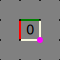

In [7]:
world = World()
world.world = {(0,0): [1,0,0,2], }
canvas = draw_world_svgpy(world.world, highlight_points=[(0,0)])
show_svg(canvas)

## B ↖

(-6, -2)
(('←', 0), ('↙', 0), ('←', 0), ('↙', 3), ('↙', 2))


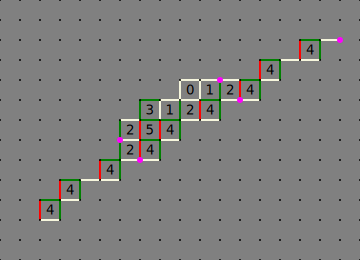

In [8]:
pv_seed = coreli.ParityVector([0, 1, 0, 1, 1])
pv = coreli.ParityVector(pv_seed.parity_vector*3)
pv_pattern = ["←" if b == 0 else "↙" for b in pv_seed]
vap_seed = ValuedPath.from_parity_vector(pv_seed)
vap = ValuedPath.from_parity_vector(pv)
world = World()
world.place_initial_valued_path(vap)

new_origin = (-1*len(pv_seed)-1, -1*pv_seed.odd_len()+1)
print(new_origin)


#IDK why need 2 calls
next_vap = world.read(pv_pattern, pos=new_origin, compute_missing=True)
print(next_vap)
#next_vap = world.read(pv_pattern, pos=new_origin, compute_missing=True)

canvas = draw_world_svgpy(world.world, 
         highlight_points=[(0,0), 
         (-1*len(pv_seed), -1*pv_seed.odd_len()), 
         (-2*len(pv_seed), -2*pv_seed.odd_len()),
         (-2*len(pv_seed)-1, -2*pv_seed.odd_len()+1),
         new_origin])
show_svg(canvas)

#next_vap

In [14]:
def test_next_cyclic_up_right_vap_via_pv(num_tests=100, num_tests_nested=10, len_pv=10):
    for _ in range(num_tests):
        pv = coreli.ParityVector.get_random_parity_vector(len_pv)
        vap = ValuedPath.from_parity_vector(pv)

        for _ in range(num_tests_nested):
            next_vap, varrow = vap.next_cyclic_vap("↖")
    
            vap2 = deepcopy(vap)
            vap2.valued_path = (varrow,)+vap2.valued_path
    
            next_vap2 = deepcopy(next_vap)
            next_vap2.valued_path = next_vap2.valued_path + (varrow,)
            vap = next_vap

        assert(vap2.func() == next_vap2.func())
test_next_cyclic_up_right_vap_via_pv()

In [24]:
def test_next_cyclic_vap_via_pv(num_tests=100, num_tests_nested=10, len_pv=10):
    for _ in range(num_tests):
        pv = coreli.ParityVector.get_random_parity_vector(len_pv)
        vap = ValuedPath.from_parity_vector(pv)

        for arrow1 in ["↖", "↗", "←", "↑"]:
            for arrow2 in [arrow1, ValuedArrow.opp(arrow1)]:
                for _ in range(num_tests_nested):
                    next_vap, varrow = vap.next_cyclic_vap(arrow2)
            
                    vap2 = deepcopy(vap)
                    vap2.valued_path = (varrow,)+vap2.valued_path
            
                    next_vap2 = deepcopy(next_vap)
                    next_vap2.valued_path = next_vap2.valued_path + (varrow,)
                    vap = next_vap
    
                    assert(vap2.func() == next_vap2.func())
test_next_cyclic_vap_via_pv()

RecursionError: maximum recursion depth exceeded

## C ↗

(-4, -2)
(('←', 1), ('↙', 2), ('↙', 4), ('←', 1), ('↙', 2))


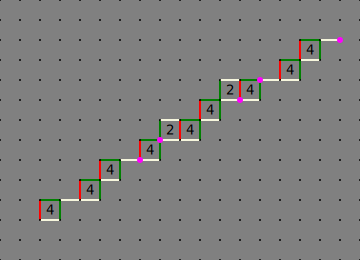

In [20]:
pv_seed = coreli.ParityVector([0,1,1,0,1])
pv = coreli.ParityVector(pv_seed.parity_vector*3)
pv_pattern = ["←" if b == 0 else "↙" for b in pv_seed]
vap_seed = ValuedPath.from_parity_vector(pv_seed)
vap = ValuedPath.from_parity_vector(pv)
world = World()
world.place_initial_valued_path(vap)

new_origin = (-1*len(pv_seed)+1, -1*pv_seed.odd_len()+1)
print(new_origin)


#IDK why need 2 calls
next_vap = world.read(pv_pattern, pos=new_origin, compute_missing=True)
print(next_vap)
#next_vap = world.read(pv_pattern, pos=new_origin, compute_missing=True)

canvas = draw_world_svgpy(world.world, 
         highlight_points=[(0,0), 
         (-1*len(pv_seed), -1*pv_seed.odd_len()), 
         (-2*len(pv_seed), -2*pv_seed.odd_len()),
         (-2*len(pv_seed)+1, -2*pv_seed.odd_len()+1),
         new_origin])
show_svg(canvas)

In [21]:
vap_seed.next_cyclic_vap('↗')[0]

(('←', 1), ('↙', 2), ('↙', 4), ('←', 1), ('↙', 2))

In [19]:
vap_seed.next_cyclic_vap('↗')[1]

('↙', 4)